# Bipartite two level systems: density matrix check

The *Permutational Invariant Quantum Solver (PIQS)* is an open-source Python solver to study the exact Lindbladian dynamics of open quantum systems consisting of identical qubits. It is integrated in QuTiP and can be imported as a model.

This tutorial is meant to check whether the results obtained with the PIQS method are equivalent to the ones obtained with QuTiP standard approach. The PIQS method represents the density matrix of the states in the Dicke basis whereas the QuTiP standard approach is to exploit the uncupled basis. The Dicke basis is degenerate with respect to the uncoupled one (hence it contains fewer states) and it is precisely this degeneracy that is at the core of the PIQS method. As a matter of fact, this degeneracy captures the permutational ivariance of the system. The master equation which describes the physics involved is in fact invariant under permutations of TLSs. The Dicke basis, which consists of the eigenstates of the collecitve spin operator, captures this invariance and it represents the system without loss of information. Every possible states is represented in the Dicke basis as a block diagonal matrix.

The equivalence between the two methods is proven for the simple case of one species TLSs both with and without a common bosonic coupling. The original step is thus to prove that this equivalence is valid for two species in a bosonic cavity as well.

This is achieved in the following way:

1. The initial density matrix is prepared in the Dicke basis and converted to the uncoupled basis.
2. Each initial state is passed to the corresponding method and the master equation is solved in both cases
3. The resulting density matrices are compared: To do so the density matrix in the unoupled basis is reconverted to the Dicke basis.
4. It is useful to look at the difference between the density matrices elements obtained with the two methods. 

We expect to obeserve small differences in the elements of the two matrices if the methods are equivalent

In [1]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

time: 18.3 ms


In [2]:
import initial_states as library

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import linalg

from qutip import *
from qutip import piqs

time: 2.04 s


In [3]:
plt.rcParams["figure.figsize"] = (12,8)

time: 79.9 ms


In [4]:
def plot_state (density):
    density_real = np.absolute(density)
    fig = plt.figure(figsize=(4, 3))
    label_size = 16

    plt.rc('xtick', labelsize=label_size) 
    plt.rc('ytick', labelsize=label_size)

    ax1 = fig.add_subplot(111)
    ax1.set_title('density matrix', fontsize=label_size)
    ax1.set_xticks([])
    ax1.set_yticks([])
    im1 = ax1.imshow(density_real, interpolation='None', cmap='Blues', norm=mpl.colors.LogNorm())
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.10)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    plt.show()
    plt.close()

time: 87.2 ms


<h1><center> One species: 2 TLSs </center></h1>
\begin{eqnarray}
H_\text{TLS}&=&\hbar\omega_0 J_z+\hbar\omega_x J_x 
\end{eqnarray}

\begin{eqnarray}
\dot{\rho} = \mathcal{D}_\text{TLS}(\rho)
&=&-\frac{i}{\hbar}\lbrack H_\text{TLS},\rho \rbrack\\
&&+\frac{\gamma_\Downarrow}{2}\mathcal{L}_{J_{-}}[\rho]
+\frac{\gamma_\Phi}{2}\mathcal{L}_{J_{z}}[\rho]
+\frac{\gamma_\Uparrow}{2}\mathcal{L}_{J_{+}}[\rho]\\
&&+\sum_{n=1}^{N}\left(
\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{-,n}}[\rho]
+\frac{\gamma_\text{D}}{2}\mathcal{L}_{J_{z,n}}[\rho]
+\frac{\gamma_\text{P}}{2}\mathcal{L}_{J_{+,n}}[\rho]\right)
\end{eqnarray}

In [5]:
N = 2

time: 57 ms


In [6]:
unc_to_dicke = [[1.,0,0,0],
                [0,1/np.sqrt(2), 1/np.sqrt(2),0],
                [0,0,0,1.],
                [0,1/np.sqrt(2), -1/np.sqrt(2),0]]
dicke_to_unc = linalg.inv(unc_to_dicke)

time: 50.6 ms


In [7]:
dicke_to_unc

array([[ 1.        , -0.        , -0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.        ,  0.70710678],
       [ 0.        ,  0.70710678,  0.        , -0.70710678],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])

time: 35.9 ms


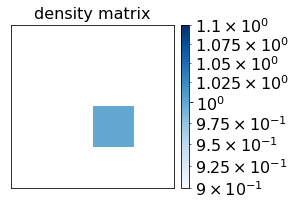

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

time: 907 ms


In [8]:
initial_state_piqs = piqs.ground(N)
plot_state(initial_state_piqs)
np.real(initial_state_piqs)

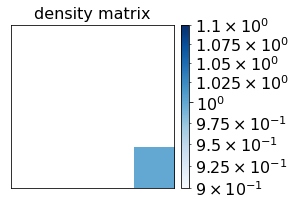

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

time: 628 ms


In [9]:
initial_state_qutip = Qobj(np.dot(np.dot(dicke_to_unc, initial_state_piqs), unc_to_dicke))
plot_state(initial_state_qutip)
np.real(initial_state_qutip)

#### Time evolution and transformation

In [10]:
piqs_state = library.one_species_piqs_mesolve(2, initial_state_piqs)[-1]
piqs_state = np.array(piqs_state)
np.real(piqs_state)

array([[ 2.49919922e-01,  5.66624173e-06, -1.03767650e-07,
         0.00000000e+00],
       [ 5.66624173e-06,  2.50122244e-01,  9.00356627e-06,
         0.00000000e+00],
       [-1.03767650e-07,  9.00356627e-06,  2.50262138e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.49695696e-01]])

time: 245 ms


In [11]:
qutip_state = np.array(library.one_species_qutip_mesolve(2, initial_state_qutip)[-1])
np.real(qutip_state)

array([[ 2.49919928e-01,  4.00270366e-06,  4.00270366e-06,
        -1.03776871e-07],
       [ 4.00270366e-06,  2.49908972e-01,  2.13275018e-04,
         6.36283449e-06],
       [ 4.00270366e-06,  2.13275018e-04,  2.49908972e-01,
         6.36283449e-06],
       [-1.03776871e-07,  6.36283449e-06,  6.36283449e-06,
         2.50262127e-01]])

time: 363 ms


In [12]:
qutip_state_transformed = np.dot(np.dot(unc_to_dicke, qutip_state), dicke_to_unc)

time: 27.3 ms


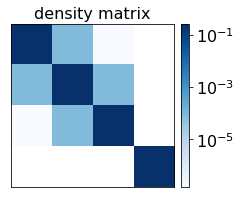

array([[ 2.49919922e-01+1.35927346e-20j,  5.66624173e-06-8.30664755e-05j,
        -1.03767650e-07-8.71029391e-08j,  0.00000000e+00+0.00000000e+00j],
       [ 5.66624173e-06+8.30664755e-05j,  2.50122244e-01+2.24561972e-21j,
         9.00356627e-06-8.11527460e-05j,  0.00000000e+00+0.00000000e+00j],
       [-1.03767650e-07+8.71029391e-08j,  9.00356627e-06+8.11527460e-05j,
         2.50262138e-01-1.74280002e-20j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  2.49695696e-01+1.58964585e-21j]])

time: 306 ms


In [13]:
plot_state(piqs_state)
piqs_state

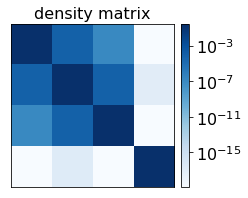

array([[ 2.49919928e-01-2.23944273e-20j,  5.66067780e-06-8.30821984e-05j,
        -1.03776871e-07-8.71198220e-08j,  1.20335598e-19-1.69405926e-19j],
       [ 5.66067780e-06+8.30821984e-05j,  2.50122247e-01+1.86384210e-21j,
         8.99840682e-06-8.11680713e-05j, -1.25985501e-17-2.66246958e-20j],
       [-1.03776871e-07+8.71198220e-08j,  8.99840682e-06+8.11680713e-05j,
         2.50262127e-01+2.21054595e-20j, -6.23855961e-20+9.95172487e-20j],
       [ 1.23539078e-19+2.41020681e-20j,  2.24355176e-17-1.23903418e-20j,
         4.26894883e-20+3.47098769e-19j,  2.49695697e-01-1.57487427e-21j]])

time: 325 ms


In [14]:
plot_state(qutip_state_transformed)
qutip_state_transformed

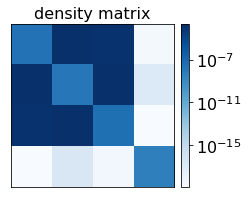

max value =  0.00020028041614178244


array([[2.37357406e-08, 2.00280416e-04, 1.41972556e-04, 2.07795630e-19],
       [2.00280416e-04, 1.31122999e-08, 1.98009121e-04, 1.25985782e-17],
       [1.41972556e-04, 1.98009121e-04, 4.08759673e-08, 1.17454865e-19],
       [1.25868239e-19, 2.24355211e-17, 3.49714094e-19, 4.07693836e-09]])

time: 286 ms


In [15]:
rel_diff = np.absolute(np.divide(qutip_state_transformed-piqs_state, qutip_state_transformed))
qutip_state_transformed = np.absolute(qutip_state_transformed)
mask = (piqs_state == 0)
rel_diff[mask] = qutip_state_transformed[mask]
plot_state(rel_diff)
print('max value = ', rel_diff.max())
rel_diff

<h1><center> One species: 2 TLSs in drive cavity</center></h1>
\begin{eqnarray}
H_\text{TLS}&=&\hbar\omega_0 J_z+\hbar\omega_x J_x 
\quad \quad \quad 
H_\text{phot} = \hbar \omega_c a^\dagger a
\quad \quad \quad
H_\text{int} = \hbar g (a^\dagger + a) J_x
\end{eqnarray}

\begin{eqnarray}
\dot{\rho} = \mathcal{D}_\text{TLS}(\rho)+\mathcal{D}_\text{phot}(\rho) -\frac{i}{\hbar}\lbrack H_\text{int}, \rho\rbrack
&=&-\frac{i}{\hbar}\lbrack H_\text{TLS}+H_\text{phot}+H_\text{int},\rho \rbrack\\
&&+\frac{\gamma_\Downarrow}{2}\mathcal{L}_{J_{-}}[\rho]
+\frac{\gamma_\Phi}{2}\mathcal{L}_{J_{z}}[\rho]
+\frac{\gamma_\Uparrow}{2}\mathcal{L}_{J_{+}}[\rho]\\
&&+\frac{w_p}{2}\mathcal{L}_{a^\dagger}[\rho]
+\frac{\kappa}{2}\mathcal{L}_{a}[\rho]\\
&&+\sum_{n=1}^{N}\left(
\frac{\gamma_\text{E}}{2}\mathcal{L}_{J_{-,n}}[\rho]
+\frac{\gamma_\text{D}}{2}\mathcal{L}_{J_{z,n}}[\rho]
+\frac{\gamma_\text{P}}{2}\mathcal{L}_{J_{+,n}}[\rho]\right)
\end{eqnarray}

In [16]:
N = 2

time: 35 ms


In [17]:
unc_to_dicke = [[1.,0,0,0],
                [0,1/np.sqrt(2), 1/np.sqrt(2),0],
                [0,0,0,1.],
                [0,1/np.sqrt(2), -1/np.sqrt(2),0]]
dicke_to_unc = linalg.inv(unc_to_dicke)

id_phot = [[1.,0.],[0.,1.]]
unc_dicke_phot = np.kron(unc_to_dicke, id_phot) 

dicke_unc_phot = linalg.inv(unc_dicke_phot)

time: 36.9 ms


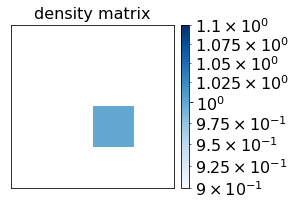

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.]])

time: 835 ms


In [18]:
initial_state_piqs = piqs.ground(N)
plot_state(initial_state_piqs)
np.real(initial_state_piqs)

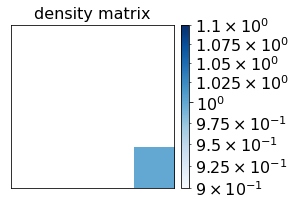

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.]])

time: 605 ms


In [19]:
initial_state_qutip = Qobj(np.dot(np.dot(dicke_to_unc, initial_state_piqs), unc_to_dicke))
plot_state(initial_state_qutip)
np.real(initial_state_qutip)

#### Time evolution and transformation

In [20]:
piqs_state = np.array(library.one_species_piqs_mesolve(2,initial_state_piqs,2)[-1])
np.real(piqs_state)

array([[ 1.26041455e-01, -8.71768503e-05, -8.88187122e-04,
        -8.44214785e-03, -1.03418905e-03, -3.05710213e-07,
         0.00000000e+00,  0.00000000e+00],
       [-8.71768503e-05,  1.00234005e-01, -9.24001882e-03,
        -9.50925485e-04,  7.82388936e-05,  1.41470583e-03,
         0.00000000e+00,  0.00000000e+00],
       [-8.88187122e-04, -9.24001882e-03,  1.29009737e-01,
         2.19759122e-04, -1.24786359e-03, -8.46273311e-03,
         0.00000000e+00,  0.00000000e+00],
       [-8.44214785e-03, -9.50925485e-04,  2.19759122e-04,
         1.20501349e-01, -1.02770644e-02, -7.46803971e-04,
         0.00000000e+00,  0.00000000e+00],
       [-1.03418905e-03,  7.82388936e-05, -1.24786359e-03,
        -1.02770644e-02,  1.52475749e-01,  4.62982239e-04,
         0.00000000e+00,  0.00000000e+00],
       [-3.05710213e-07,  1.41470583e-03, -8.46273311e-03,
        -7.46803971e-04,  4.62982239e-04,  1.21931520e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.000000

time: 347 ms


In [21]:
qutip_state = library.one_species_qutip_mesolve(2,initial_state_qutip,2)[-1]
np.real(qutip_state)

array([[ 1.26088795e-01, -8.99352860e-05, -6.09607068e-04,
        -5.78448300e-03, -6.08040584e-04, -5.74730111e-03,
        -1.02936873e-03,  1.06065550e-05],
       [-8.99352860e-05,  1.00718842e-01, -6.33745209e-03,
        -6.53610120e-04, -6.35374501e-03, -6.61052403e-04,
         7.12899341e-05,  1.38355676e-03],
       [-6.09607068e-04, -6.33745209e-03,  1.46610125e-01,
         1.16701460e-04, -1.78550120e-02,  9.00419166e-05,
        -8.54302266e-04, -5.75444789e-03],
       [-5.78448300e-03, -6.53610120e-04,  1.16701460e-04,
         1.03272915e-01,  8.99577513e-05,  1.73406280e-02,
        -7.04430686e-03, -5.18714692e-04],
       [-6.08040584e-04, -6.35374501e-03, -1.78550120e-02,
         8.99577513e-05,  1.46586608e-01,  1.11519988e-04,
        -8.48732769e-04, -5.79621038e-03],
       [-5.74730111e-03, -6.61052403e-04,  9.00419166e-05,
         1.73406280e-02,  1.11519988e-04,  1.03266074e-01,
        -7.02374696e-03, -5.19681086e-04],
       [-1.02936873e-03,  7.128993

time: 401 ms


In [22]:
qutip_state_transformed = np.dot(np.dot(unc_dicke_phot, qutip_state), dicke_unc_phot)

time: 27.2 ms


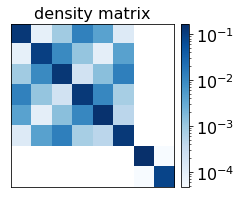

array([[ 1.26041455e-01+4.19954374e-18j, -8.71768503e-05+2.84007359e-05j,
        -8.88187122e-04+1.34314041e-04j, -8.44214785e-03+9.51235845e-03j,
        -1.03418905e-03+4.17035726e-03j, -3.05710213e-07-1.34272593e-04j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [-8.71768503e-05-2.84007359e-05j,  1.00234005e-01-4.07426647e-19j,
        -9.24001882e-03-2.94310289e-03j, -9.50925485e-04-6.69914635e-04j,
         7.82388936e-05+6.42078029e-05j,  1.41470583e-03-4.17445321e-03j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [-8.88187122e-04-1.34314041e-04j, -9.24001882e-03+2.94310289e-03j,
         1.29009737e-01+1.14170332e-19j,  2.19759122e-04-3.74502366e-05j,
        -1.24786359e-03-8.14107711e-04j, -8.46273311e-03+1.03869346e-02j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [-8.44214785e-03-9.51235845e-03j, -9.50925485e-04+6.69914635e-04j,
         2.19759122e-04+3.74502366e

time: 426 ms


In [23]:
plot_state(piqs_state)
np.array(piqs_state)

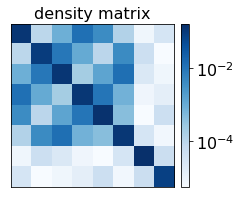

array([[ 1.26088795e-01+9.08711697e-19j, -8.99352860e-05+3.35834057e-05j,
        -8.61006912e-04+1.35907330e-04j, -8.15420274e-03+9.42125105e-03j,
        -1.02936873e-03+4.13666327e-03j,  1.06065550e-05-1.29655276e-04j,
        -1.10767149e-06-7.67241347e-06j, -2.62915704e-05+1.59045467e-05j],
       [-8.99352860e-05-3.35834057e-05j,  1.00718842e-01-3.39943899e-19j,
        -8.97403153e-03-2.94491403e-03j, -9.29606785e-04-6.59898414e-04j,
         7.12899341e-05+6.64253537e-05j,  1.38355676e-03-4.13333970e-03j,
         1.15208399e-05-4.94939132e-05j,  5.26248895e-06+6.20607751e-07j],
       [-8.61006912e-04-1.35907330e-04j, -8.97403153e-03+2.94491403e-03j,
         1.28743355e-01+2.94993332e-19j,  2.04110558e-04-3.22792512e-05j,
        -1.20422762e-03-8.15378528e-04j, -8.16754879e-03+1.02488868e-02j,
         1.17585692e-05+1.94221287e-05j,  2.54865320e-06+7.37081173e-06j],
       [-8.15420274e-03-9.42125105e-03j, -9.29606785e-04+6.59898414e-04j,
         2.04110558e-04+3.22792512e

time: 252 ms


In [24]:
plot_state(qutip_state_transformed)
qutip_state_transformed

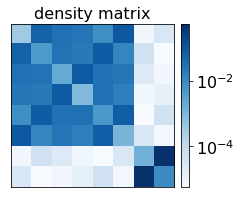

max value =  0.5402041291906462


array([[3.75456745e-04, 6.11559321e-02, 3.12353941e-02, 2.42387959e-02,
        7.98464116e-03, 9.10836874e-02, 7.75195876e-06, 3.07278584e-05],
       [6.11559321e-02, 4.81376312e-03, 2.81627134e-02, 2.06615142e-02,
        7.48584130e-02, 1.18338576e-02, 5.08170955e-05, 5.29895687e-06],
       [3.12353941e-02, 2.81627134e-02, 2.06909965e-03, 7.97532999e-02,
        3.00173892e-02, 2.48655045e-02, 2.27042515e-05, 7.79900626e-06],
       [2.42387959e-02, 2.06615142e-02, 7.97532999e-02, 9.01858764e-04,
        3.13453250e-02, 1.67399277e-02, 8.01186344e-06, 1.42313470e-05],
       [7.98464116e-03, 7.48584130e-02, 3.00173892e-02, 3.13453250e-02,
        5.32606214e-03, 6.96646600e-02, 5.33909566e-06, 5.07426999e-05],
       [9.10836874e-02, 1.18338576e-02, 2.48655045e-02, 1.67399277e-02,
        6.96646600e-02, 1.17281477e-03, 3.03801526e-05, 7.08232438e-06],
       [7.75195876e-06, 5.08170955e-05, 2.27042515e-05, 8.01186344e-06,
        5.33909566e-06, 3.03801526e-05, 1.35617483e-03, 5.

time: 295 ms


In [25]:
rel_diff = np.absolute(np.divide(qutip_state_transformed-piqs_state, qutip_state_transformed))
qutip_state_transformed = np.absolute(qutip_state_transformed)
mask = (piqs_state == 0)
rel_diff[mask] = qutip_state_transformed[mask]
plot_state(rel_diff)
print('max value = ', rel_diff.max())
rel_diff

<h1><center> Two species: 2 TLSs each </center></h1>
\begin{eqnarray}
H_\text{TLS}^{(1)}&=&\hbar\omega_{0}^{(1)} J_{z}^{(1)}+\hbar\omega_{x}^{(1)} J_{x}^{(1)} \quad \quad
H_\text{TLS}^{(2)}&=&\hbar\omega_{0}^{(2)} J_{z}^{(2)}+\hbar\omega_{x}^{(2)} J_{x}^{(2)}
\end{eqnarray}

\begin{eqnarray}
\dot{\rho} = \mathcal{D}_\text{TLS}(\rho)&=& 
-\frac{i}{\hbar}\lbrack H_\text{TLS}^{(1)} 
+H_\text{TLS}^{(2)},\rho \rbrack\\
&&
+\frac{\gamma_\Downarrow}{2}\mathcal{L}_{J_-}[\rho]
+\frac{\gamma_\Phi}{2}\mathcal{L}_{J_z}[\rho]
+\frac{\gamma_\Uparrow}{2}\mathcal{L}_{J_+}[\rho]\\
&&
+\sum_{n=1}^{N_1}\frac{\gamma_\downarrow^{(1)}}{2}\mathcal{L}_{J_{-,n}^{(1)}}[\rho] 
+\frac{\gamma_\phi^{(1)}}{2}\mathcal{L}_{J_{z,n}^{(1)}}[\rho] 
+\frac{\gamma_\uparrow^{(1)}}{2}\mathcal{L}_{J_{+,n}^{(1)}}[\rho] \\
&&
+\sum_{n=1}^{N_2}\frac{\gamma_\downarrow^{(2)}}{2}\mathcal{L}_{J_{-,n}^{(2)}}[\rho]
+\frac{\gamma_\phi^{(2)}}{2}\mathcal{L}_{J_{z,n}^{(2)}}[\rho]
+\frac{\gamma_\uparrow^{(2)}}{2}\mathcal{L}_{J_{+,n}^{(2)}}[\rho]
\end{eqnarray}

In [26]:
N1 = 2
N2 = 2

time: 28.7 ms


In [27]:
unc_to_dicke = [[1.,0,0,0],
                [0,1/np.sqrt(2),1/np.sqrt(2),0],
                [0,0,0,1.],
                [0,1/np.sqrt(2),-1/np.sqrt(2),0]]
dicke_to_unc = linalg.inv(unc_to_dicke)

unc_dicke_two = np.kron(unc_to_dicke, unc_to_dicke)

dicke_unc_two = linalg.inv(unc_dicke_two)

time: 33.1 ms


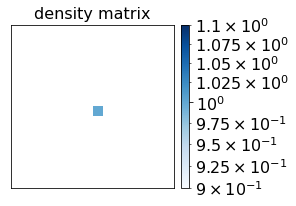

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

time: 497 ms


In [28]:
initial_state_piqs_1 = piqs.ground(N1)
initial_state_piqs_2 = piqs.excited(N2)
plot_state(tensor(initial_state_piqs_1, initial_state_piqs_2))
np.real(tensor(initial_state_piqs_1, initial_state_piqs_2))

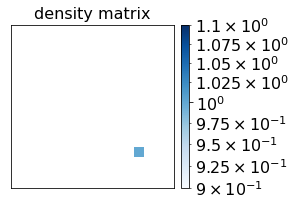

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

time: 516 ms


In [29]:
initial_state_qutip_1 = Qobj(np.dot(np.dot(dicke_to_unc, initial_state_piqs_1), unc_to_dicke))
initial_state_qutip_2 = Qobj(np.dot(np.dot(dicke_to_unc, initial_state_piqs_2), unc_to_dicke))
plot_state(tensor(initial_state_qutip_1, initial_state_qutip_2))
np.real(tensor(initial_state_qutip_1, initial_state_qutip_2))

#### Time evolution and transformation

In [30]:
piqs_state = np.array(library.two_species_piqs_mesolve(N1,N2,initial_state_piqs_1,initial_state_piqs_2)[-1])
np.real(piqs_state)

array([[ 6.24910490e-02,  3.60223546e-06, -7.08505127e-10,
         0.00000000e+00, -3.52995527e-06,  1.42356087e-09,
         1.71924596e-13,  0.00000000e+00, -7.15226466e-10,
        -1.76223632e-13, -1.32957523e-16,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.60223546e-06,  6.25048374e-02,  3.67536966e-06,
         0.00000000e+00, -2.10117172e-05, -3.60316230e-06,
         1.41701025e-09,  0.00000000e+00,  9.11955798e-10,
        -7.11997812e-10, -1.71924596e-13,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-7.08505127e-10,  3.67536966e-06,  6.25155169e-02,
         0.00000000e+00, -9.26836219e-10, -2.10130954e-05,
        -3.67536966e-06,  0.00000000e+00,  2.34858722e-09,
         9.26836219e-10, -7.08505127e-10,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e

time: 385 ms


In [31]:
qutip_state = library.two_species_qutip_mesolve(N1,N2,initial_state_qutip_1,initial_state_qutip_2)[-1]
np.real(qutip_state)

array([[ 6.24910634e-02,  2.54059108e-06,  2.54059108e-06,
        -7.07583192e-10, -2.48956335e-06,  7.10855977e-10,
         7.10855977e-10,  1.22450355e-13, -2.48956335e-06,
         7.10855977e-10,  7.10855977e-10,  1.22450355e-13,
        -7.14298455e-10, -1.25470599e-13, -1.25470599e-13,
        -1.32108643e-16],
       [ 2.54059108e-06,  6.24943433e-02,  1.04896616e-05,
         2.59221604e-06, -1.04889767e-05, -2.54059108e-06,
        -6.48119530e-10,  7.07583192e-10, -1.04889767e-05,
        -2.54059108e-06, -6.48119530e-10,  7.07583192e-10,
         6.37665057e-10, -7.10855977e-10, -2.16090230e-13,
        -1.22450355e-13],
       [ 2.54059108e-06,  1.04896616e-05,  6.24943433e-02,
         2.59221604e-06, -1.04889767e-05, -6.48119530e-10,
        -2.54059108e-06,  7.07583192e-10, -1.04889767e-05,
        -6.48119530e-10, -2.54059108e-06,  7.07583192e-10,
         6.37665057e-10, -2.16090230e-13, -7.10855977e-10,
        -1.22450355e-13],
       [-7.07583192e-10,  2.59221604e

time: 638 ms


In [32]:
qutip_state_transformed = np.dot(np.dot(unc_dicke_two, qutip_state), dicke_unc_two)

time: 26.3 ms


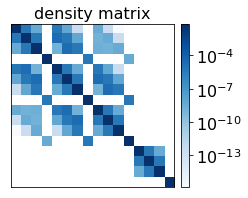

array([[ 6.24910490e-02+1.32893298e-21j,  3.60223546e-06-3.36425733e-06j,
        -7.08505127e-10-4.00268163e-09j,  0.00000000e+00+0.00000000e+00j,
        -3.52995527e-06+3.46785077e-06j,  1.42356087e-09+8.00710379e-09j,
         1.71924596e-13+2.53680127e-13j,  0.00000000e+00+0.00000000e+00j,
        -7.15226466e-10-4.00514986e-09j, -1.76223632e-13-2.51764919e-13j,
        -1.32957523e-16-2.71833198e-17j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 3.60223546e-06+3.36425733e-06j,  6.25048374e-02+1.37707959e-21j,
         3.67536966e-06-3.26151036e-06j,  0.00000000e+00+0.00000000e+00j,
        -2.10117172e-05-2.44375855e-21j, -3.60316230e-06+3.36520855e-06j,
         1.41701025e-09+8.00536325e-09j,  0.00000000e+00+0.00000000e+00j,
         9.11955798e-10-9.73121648e-10j, -7.11997812e-10-4.00480116e-09j,
        -1.71924596e-13-2.53680127e-1

time: 363 ms


In [33]:
plot_state(piqs_state)
np.array(piqs_state)

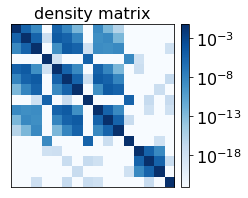

array([[ 6.24910634e-02-4.87176490e-23j,  3.59293836e-06-3.37902142e-06j,
        -7.07583192e-10-3.99628205e-09j, -5.12848632e-20-1.48834848e-19j,
        -3.52077426e-06+3.48244847e-06j,  1.42171195e-09+7.99425122e-09j,
         1.73170953e-13+2.51522340e-13j, -2.95456127e-21+3.31489613e-21j,
        -7.14298455e-10-3.99869218e-09j, -1.77442223e-13-2.49619131e-13j,
        -1.32108643e-16-2.69924123e-17j, -7.36624795e-23-1.53474223e-23j,
         4.59089903e-20-4.09713129e-20j,  1.04404330e-22+9.93827326e-22j,
        -6.75964603e-23+2.68119986e-23j,  2.45902839e-21-3.11306406e-21j],
       [ 3.59293836e-06+3.37902142e-06j,  6.25048330e-02+7.33394038e-22j,
         3.66594708e-06-3.27644403e-06j,  3.25837658e-18+2.05329922e-22j,
        -2.09779534e-05+2.53749229e-22j, -3.59385494e-06+3.37997603e-06j,
         1.41516638e-09+7.99256411e-09j, -3.39994562e-20-1.17395810e-19j,
         9.01794571e-10-9.76371300e-10j, -7.11072067e-10-3.99836684e-09j,
        -1.73170953e-13-2.51522339e-1

time: 308 ms


In [34]:
plot_state(qutip_state_transformed)
qutip_state_transformed

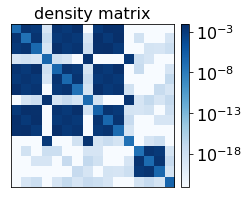

max value =  0.00816274705457181


array([[2.30151889e-07, 3.53743515e-03, 1.59313314e-03, 1.57422836e-19,
        3.48232496e-03, 1.59918361e-03, 8.16015287e-03, 4.44049194e-21,
        1.60611343e-03, 8.05740802e-03, 6.45279810e-03, 7.52442972e-23,
        6.15327869e-20, 9.99296262e-22, 7.27197684e-23, 3.96711336e-21],
       [3.53743515e-03, 7.02920110e-08, 3.59137845e-03, 3.25837659e-18,
        1.60948762e-03, 3.53817708e-03, 1.59313313e-03, 1.22220045e-19,
        8.02658190e-03, 1.60069225e-03, 8.16015318e-03, 1.27323765e-21,
        4.74986754e-19, 5.93671694e-20, 9.16133702e-22, 1.38354400e-19],
       [1.59313314e-03, 3.59137845e-03, 2.90722313e-07, 1.37463690e-19,
        8.16274705e-03, 1.60978206e-03, 3.59137845e-03, 1.31597165e-18,
        6.46377811e-03, 8.16274697e-03, 1.59313314e-03, 4.64287708e-20,
        3.41843997e-20, 2.46169035e-19, 7.80864592e-20, 1.62005648e-18],
       [1.41668461e-19, 5.04362685e-19, 1.43550821e-19, 4.70178228e-07,
        1.13947210e-18, 1.19375224e-19, 4.33572280e-21, 3.536

time: 317 ms


In [35]:
rel_diff = np.absolute(np.divide(qutip_state_transformed-piqs_state, qutip_state_transformed))
qutip_state_transformed = np.absolute(qutip_state_transformed)
mask = (piqs_state == 0)
rel_diff[mask] = qutip_state_transformed[mask]
plot_state(rel_diff)
print('max value = ', rel_diff.max())
rel_diff

<h1><center> Two species: 2 TLSs each in driven leaky cavity </center></h1>

\begin{eqnarray}
H_\text{TLS}^{(1)}&=&\hbar\omega_{0}^{(1)} J_{z}^{(1)}+\hbar\omega_{x}^{(1)} J_{x}^{(1)} \quad \quad
H_\text{TLS}^{(2)}&=&\hbar\omega_{0}^{(2)} J_{z}^{(2)}+\hbar\omega_{x}^{(2)} J_{x}^{(2)} \quad \quad
H_\text{phot} = \hbar \omega_c a^\dagger a \quad \quad
H_\text{int} = \hbar g (a^\dagger + a) (J_x^{(1)}+J_x^{(2)})
\end{eqnarray}

\begin{eqnarray}
\dot{\rho} = \mathcal{D}_\text{TLS}^{(1)}(\rho)+\mathcal{D}_\text{TLS}^{(2)}(\rho)+\mathcal{D}_\text{phot}(\rho) -\frac{i}{\hbar}\lbrack H_\text{int}, \rho\rbrack
&=&-\frac{i}{\hbar}\lbrack H_\text{TLS}^{(1)}+H_\text{TLS}^{(2)}+H_\text{phot}+H_\text{int},\rho \rbrack\\
&&
+\frac{\gamma_\Downarrow}{2}\mathcal{L}_{J_-}[\rho]
+\frac{\gamma_\Phi}{2}\mathcal{L}_{J_z}[\rho]
+\frac{\gamma_\Uparrow}{2}\mathcal{L}_{J_+}[\rho]\\
&&+\frac{w_p}{2}\mathcal{L}_{a^\dagger}[\rho]
+\frac{\kappa}{2}\mathcal{L}_{a}[\rho]\\
&&
+\sum_{n=1}^{N_1}\frac{\gamma_\downarrow^{(1)}}{2}\mathcal{L}_{J_{-,n}^{(1)}}[\rho] 
+\frac{\gamma_\phi^{(1)}}{2}\mathcal{L}_{J_{z,n}^{(1)}}[\rho] 
+\frac{\gamma_\uparrow^{(1)}}{2}\mathcal{L}_{J_{+,n}^{(1)}}[\rho] \\
&&
+\sum_{n=1}^{N_2}\frac{\gamma_\downarrow^{(2)}}{2}\mathcal{L}_{J_{-,n}^{(2)}}[\rho]
+\frac{\gamma_\phi^{(2)}}{2}\mathcal{L}_{J_{z,n}^{(2)}}[\rho]
+\frac{\gamma_\uparrow^{(2)}}{2}\mathcal{L}_{J_{+,n}^{(2)}}[\rho]
\end{eqnarray}

In [36]:
N1 = 2
N2 = 2

time: 29.4 ms


In [37]:
unc_to_dicke = [[1.,0,0,0],
                [0,1/np.sqrt(2), 1/np.sqrt(2),0],
                [0,0,0,1.],
                [0,1/np.sqrt(2), -1/np.sqrt(2),0]]
dicke_to_unc = linalg.inv(unc_to_dicke)

unc_dicke_two = np.kron(unc_to_dicke, unc_to_dicke)

id_phot = [[1.,0.],[0.,1.]]
unc_dicke_two_phot = np.kron(unc_dicke_two, id_phot)

dicke_unc_two_phot = linalg.inv(unc_dicke_two_phot)

time: 28.2 ms


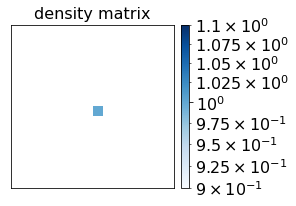

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

time: 588 ms


In [38]:
initial_state_piqs_1 = piqs.ground(N1)
initial_state_piqs_2 = piqs.excited(N2)
plot_state(tensor(initial_state_piqs_1, initial_state_piqs_2))
np.real(tensor(initial_state_piqs_1, initial_state_piqs_2))

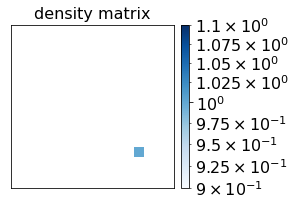

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

time: 563 ms


In [39]:
initial_state_qutip_1 = Qobj(np.dot(np.dot(dicke_to_unc, initial_state_piqs_1), unc_to_dicke))
initial_state_qutip_2 = Qobj(np.dot(np.dot(dicke_to_unc, initial_state_piqs_2), unc_to_dicke))
plot_state(tensor(initial_state_qutip_1, initial_state_qutip_2))
np.real(tensor(initial_state_qutip_1, initial_state_qutip_2))

In [40]:
piqs_state = np.array(library.two_species_piqs_mesolve(N1,N2,initial_state_piqs_1,initial_state_piqs_2,2,g1=10,g2=20)[-1])
np.real(piqs_state)

array([[ 3.21326436e-02,  2.30467764e-05, -2.94972914e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.30467764e-05,  2.43352432e-02, -1.59337515e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.94972914e-05, -1.59337515e-05,  3.73299638e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.26430758e-02,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.27509409e-02, -1.44938251e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -1.44938251e-05,  2.01009172e-02]])

time: 915 ms


In [41]:
qutip_state = library.two_species_qutip_mesolve(N1,N2,initial_state_qutip_1,initial_state_qutip_2,2,g1=10,g2=20)[-1]
np.real(qutip_state)

array([[ 3.21326207e-02,  2.30468102e-05, -2.08580007e-05, ...,
         3.01924559e-06,  1.62025579e-03, -9.18665244e-07],
       [ 2.30468102e-05,  2.43352058e-02, -1.12668486e-05, ...,
        -1.84569907e-06, -8.72863240e-07, -1.17833725e-03],
       [-2.08580007e-05, -1.12668486e-05,  4.15334915e-02, ...,
         7.97015170e-07, -1.15879174e-05,  1.82916221e-06],
       ...,
       [ 3.01924559e-06, -1.84569907e-06,  7.97015170e-07, ...,
         2.23525067e-02, -1.46745941e-05, -1.74651630e-05],
       [ 1.62025579e-03, -8.72863240e-07, -1.15879174e-05, ...,
        -1.46745941e-05,  3.84892796e-02, -3.40781999e-05],
       [-9.18665244e-07, -1.17833725e-03,  1.82916221e-06, ...,
        -1.74651630e-05, -3.40781999e-05,  2.87691302e-02]])

time: 1.37 s


In [42]:
qutip_state_transformed = np.dot(np.dot(unc_dicke_two_phot, qutip_state), dicke_unc_two_phot)

time: 29.7 ms


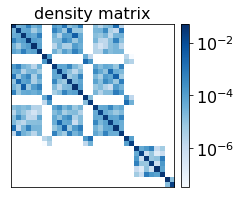

0.04934741608107237


array([[ 3.21326436e-02-3.91655992e-20j,  2.30467764e-05+1.75166648e-05j,
        -2.94972914e-05-3.24109148e-05j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 2.30467764e-05-1.75166648e-05j,  2.43352432e-02-1.21452915e-19j,
        -1.59337515e-05-5.40043820e-05j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [-2.94972914e-05+3.24109148e-05j, -1.59337515e-05+5.40043820e-05j,
         3.73299638e-02-6.33735739e-20j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       ...,
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         3.26430758e-02+5.55737380e-21j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.

time: 312 ms


In [43]:
plot_state(piqs_state)
print(np.absolute(piqs_state).max())
np.array(piqs_state)

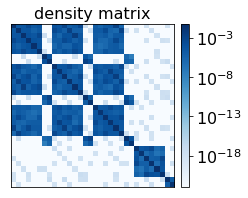

array([[ 3.21326207e-02-3.42829205e-20j,  2.30468102e-05+1.75168620e-05j,
        -2.94976675e-05-3.24110841e-05j, ...,
         2.43754099e-19-1.92908386e-19j, -7.05900859e-19+1.18282527e-19j,
        -1.47701335e-21+6.09046982e-21j],
       [ 2.30468102e-05-1.75168620e-05j,  2.43352058e-02-2.36753192e-19j,
        -1.59337301e-05-5.40041903e-05j, ...,
         6.17120280e-21+7.60197139e-21j, -4.24005941e-21+9.46284433e-22j,
         1.55054525e-20+3.73033877e-21j],
       [-2.94976675e-05+3.24110841e-05j, -1.59337301e-05+5.40041903e-05j,
         3.73299689e-02-1.04732031e-19j, ...,
         1.47340882e-20-4.60675892e-21j,  4.02653691e-22+4.79165632e-21j,
        -2.65887716e-22+4.00433434e-20j],
       ...,
       [ 1.58504401e-19+5.53858904e-19j,  9.96883055e-21+1.10944820e-20j,
         2.50017556e-20+1.15651920e-20j, ...,
         3.26431036e-02-2.04399358e-20j,  1.06551203e-20+1.77609514e-18j,
        -3.52019579e-21+6.12178863e-21j],
       [-7.03561965e-19-1.21605465e-20j,  8.

time: 300 ms


In [44]:
plot_state(qutip_state_transformed)
qutip_state_transformed

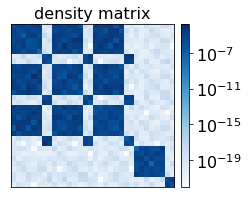

max value =  0.00015862603643780677


array([[7.12911292e-07, 6.91199545e-06, 9.41165830e-06, ...,
        3.10853191e-19, 7.15742118e-19, 6.26700814e-21],
       [6.91199545e-06, 1.53539722e-06, 3.42603529e-06, ...,
        9.79151229e-21, 4.34437084e-21, 1.59478677e-20],
       [9.41165830e-06, 3.42603529e-06, 1.38162261e-07, ...,
        1.54374733e-20, 4.80854451e-21, 4.00442261e-20],
       ...,
       [5.76093162e-19, 1.49152644e-20, 2.75470769e-20, ...,
        8.53005248e-07, 1.77612710e-18, 7.06173310e-21],
       [7.03667050e-19, 9.69904332e-21, 1.50005858e-20, ...,
        1.52200812e-18, 3.54618086e-06, 2.16351654e-05],
       [6.19270030e-21, 5.39857898e-19, 4.59288373e-20, ...,
        9.02905619e-21, 2.16351654e-05, 6.45443451e-07]])

time: 293 ms


In [45]:
rel_diff = np.absolute(np.divide(qutip_state_transformed-piqs_state, qutip_state_transformed))
qutip_state_transformed = np.absolute(qutip_state_transformed)
mask = (piqs_state == 0)
rel_diff[mask] = qutip_state_transformed[mask]
plot_state(rel_diff)
print('max value = ', rel_diff.max())
rel_diff